<a href="https://colab.research.google.com/github/DIPANJAN001/Forecasting-Solar-Energy/blob/master/optimizer10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
!pip install Boruta
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from boruta import BorutaPy
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import concatenate
from keras import Model
from keras.layers import Input
from keras.layers import Bidirectional
from keras import layers
from sklearn.metrics import mean_squared_error
from sklearn.datasets import make_classification
from sklearn.datasets import make_classification
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.layers import LeakyReLU
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import BatchNormalization
from keras.models import load_model
from keras.layers import Input
from sklearn.decomposition import PCA 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 KB 5.6 MB/s eta 0:00:00


In [2]:
def lstm_data_transform(x_data, y_data, num_steps):
    """ Changes data to the format for LSTM training 
for sliding window approach """
    # Prepare the list for the transformed data
    X, y = list(), list()
    # Loop of the entire data set
    for i in range(x_data.shape[0]):
        # compute a new (sliding window) index
        end_ix = i + num_steps
        # if index is larger than the size of the dataset, we stop
        if end_ix >= x_data.shape[0]:
            break
        # Get a sequence of data for x
        seq_X = x_data[i:end_ix]
        # Get only the last element of the sequency for y
        seq_y = y_data[end_ix]
        # Append the list with sequencies
        X.append(seq_X)
        y.append(seq_y)
    # Make final arrays
    x_array = np.array(X)
    y_array = np.array(y)
    return x_array, y_array

In [3]:
df=pd.read_excel("/content/pv_04.xlsx")
weather_input1=df.drop('power_normed',axis=1)
weather_input=weather_input1.drop('time_idx',axis=1)
solpow=df['power_normed']

In [4]:
rfc = RandomForestRegressor(random_state=1, n_estimators=1000, max_depth=10)
boruta_selector = BorutaPy(rfc, n_estimators='auto', verbose=2, random_state=1)
boruta_selector.fit(np.array(weather_input), np.array(solpow)) 

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	49
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	49
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	49
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	49
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	49
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	49
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	49
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	9
Tentative: 	8
Rejected: 	32
Iteration: 	9 / 100
Confirmed: 	9
Tentative: 	8
Rejected: 	32
Iteration: 	10 / 100
Confirmed: 	9
Tentative: 	8
Rejected: 	32
Iteration: 	11 / 100
Confirmed: 	9
Tentative: 	8
Rejected: 	32
Iteration: 	12 / 100
Confirmed: 	12
Tentative: 	5
Rejected: 	32
Iteration: 	13 / 100
Confirmed: 	12
Tentative: 	5
Rejected: 	32
Iteration: 	14 / 100
Confirmed: 	12
Tentative: 	5
Rejected: 	32
Iteration: 	15 / 100
Confirmed: 	12
Tentative: 	5
Rejected: 	32
Iteration: 	16 / 100
Confirmed: 	13
Tentative: 	4
Rejected: 

BorutaPy(estimator=RandomForestRegressor(max_depth=10, n_estimators=58,
                                         random_state=RandomState(MT19937) at 0x7F5A29AD8640),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x7F5A29AD8640, verbose=2)

In [5]:
X_important_train = boruta_selector.transform(np.array(weather_input))
num_steps = 3
# training set
(x_transformed_train,
 y_transformed_train) = lstm_data_transform(X_important_train,solpow , num_steps=num_steps)
assert x_transformed_train.shape[0] == y_transformed_train.shape[0]
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x_transformed_train,y_transformed_train,test_size=0.33, random_state=42,shuffle=False)
#X_train_,X_val,y_train_,y_val=train_test_split(X_train,y_train,test_size=0.2, random_state=42,shuffle=False)
inputs1 = Input(shape=(X_train.shape[1],X_train.shape[2]))

In [6]:
inputs1

<KerasTensor: shape=(None, 3, 16) dtype=float32 (created by layer 'input_1')>

In [7]:
from keras import optimizers

In [9]:
from keras.optimizers import Adam
import numpy as np

class SPANDAN(Adam):
    def __init__(self, num_restarts=20, num_steps=100, lr=0.003, beta_1=0.9, beta_2=0.999,
                 epsilon=1e-8, decay=0., amsgrad=False, noise_std=0.1, **kwargs):
        super(SPANDAN, self).__init__(lr, beta_1, beta_2, epsilon, decay, amsgrad, **kwargs)
        self.num_restarts = num_restarts
        self.num_steps = num_steps
        self.noise_std = noise_std
        self.best_loss = np.inf
        self.best_weights = None
        self.initial_weights = None
    
    def get_weights(self):
        return self.best_weights

    def set_weights(self, weights):
        self.best_weights = weights
        self.initial_weights = weights

    def on_train_begin(self, logs=None):
        self.best_loss = np.inf
        self.initial_weights = self.model.get_weights()

    def on_batch_end(self, batch, logs=None):
        current_loss = logs.get('loss')
        if current_loss < self.best_loss:
            self.best_loss = current_loss
            self.best_weights = self.model.get_weights()

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.num_restarts == 0 and epoch > 0:
            for _ in range(self.num_steps):
                self.model.fit(self.model.train_on_batch, epochs=1, verbose=0)
                current_loss = logs.get('loss')
                if current_loss < self.best_loss:
                    self.best_loss = current_loss
                    self.best_weights = self.model.get_weights()
            # calculate distance 
            distance = [np.linalg.norm(b - i) for b, i in zip(self.best_weights, self.initial_weights)]
            distance = sum(distance)/len(distance)
            
            # Adding noise to the best parameters
            params_1 = [b + 2*distance for b in self.best_weights]
            self.model.set_weights(params_1)
            self.initial_weights = params_1

            # subtract noise to the best parameters*s
            params_2 = [b - 2*distance for b in self.best_weights]
            self.model.set_weights(params_2)
            self.initial_weights = params_2


In [18]:
class SPANDAN1(Adam):
    def __init__(self, num_restarts=20, num_steps=100, lr=0.003, beta_1=0.9, beta_2=0.999,
                 epsilon=1e-8, decay=0., amsgrad=False, noise_std=0.1, **kwargs):
        super(SPANDAN, self).__init__(lr, beta_1, beta_2, epsilon, decay, amsgrad, **kwargs)
        self.num_restarts = num_restarts
        self.num_steps = num_steps
        self.noise_std = noise_std
        self.best_loss = np.inf
        self.best_weights = None
        self.initial_weights = None
    
    def get_weights(self):
        return self.best_weights

    def set_weights(self, weights):
        self.best_weights = weights
        self.initial_weights = weights

    def on_train_begin(self, logs=None):
        self.best_loss = np.inf
        self.initial_weights = self.model.get_weights()

    def on_batch_end(self, batch, logs=None):
        current_loss = logs.get('loss')
        if current_loss < self.best_loss:
            self.best_loss = current_loss
            self.best_weights = self.model.get_weights()

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.num_restarts == 0 and epoch > 0:
            for _ in range(self.num_steps):
                self.model.fit(self.model.train_on_batch, epochs=1, verbose=0)
                current_loss = logs.get('loss')
                if current_loss < self.best_loss:
                    self.best_loss = current_loss
                    self.best_weights = self.model.get_weights()
            # calculate distance 
            distance = [np.linalg.norm(b - i) for b, i in zip(self.best_weights, self.initial_weights)]
          
            
            # Adding noise to the best parameters
            params_1 = [b + 2*distance for b in self.best_weights]
            self.model.set_weights(params_1)
            self.initial_weights = params_1

            # subtract noise to the best parameters*s
            params_2 = [b - 2*distance for b in self.best_weights]
            self.model.set_weights(params_2)
            self.initial_weights = params_2


In [22]:
from keras.optimizers import Adam
import numpy as np

class RandomRestartAdam(Adam):
    def __init__(self, num_restarts=10, num_steps=100, lr=0.001, beta_1=0.9, beta_2=0.999,
                 epsilon=1e-8, decay=0., amsgrad=False, noise_std=0.1, **kwargs):
        super(RandomRestartAdam, self).__init__(lr, beta_1, beta_2, epsilon, decay, amsgrad, **kwargs)
        self.num_restarts = num_restarts
        self.num_steps = num_steps
        self.noise_std = noise_std
        self.best_loss = np.inf
        self.best_weights = None
        self.initial_weights = None
    
    def get_weights(self):
        return self.best_weights

    def set_weights(self, weights):
        self.best_weights = weights
        self.initial_weights = weights

    def on_train_begin(self, logs=None):
        self.best_loss = np.inf
        self.initial_weights = self.model.get_weights()

    def on_batch_end(self, batch, logs=None):
        current_loss = logs.get('loss')
        if current_loss < self.best_loss:
            self.best_loss = current_loss
            self.best_weights = self.model.get_weights()

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.num_restarts == 0 and epoch > 0:
            for _ in range(self.num_steps):
                self.model.fit(self.model.train_on_batch, epochs=1, verbose=0)
                current_loss = logs.get('loss')
                if current_loss < self.best_loss:
                    self.best_loss = current_loss
                    self.best_weights = self.model.get_weights()
            # calculate distance 
            distance = [np.linalg.norm(b - i) for b, i in zip(self.best_weights, self.initial_weights)]
            distance = sum(distance)/len(distance)
            
            # Adding noise to the best parameters
            params_1 = [b + (distance*self.noise_std) for b in self.best_weights]
            self.model.set_weights(params_1)
            self.initial_weights = params_1

            # subtract noise to the best parameters
            params_2 = [b - (distance*self.noise_std) for b in self.best_weights]
            self.model.set_weights(params_2)
            self.initial_weights = params_2


In [19]:
from keras.layers import Bidirectional

Epoch 1/75
51/51 [==============================] - 24s 126ms/step - loss: 0.0157 - mse: 0.0157 - val_loss: 0.0039 - val_mse: 0.0039
Epoch 2/75
51/51 [==============================] - 4s 84ms/step - loss: 0.0049 - mse: 0.0049 - val_loss: 0.0020 - val_mse: 0.0020
Epoch 3/75
51/51 [==============================] - 4s 87ms/step - loss: 0.0041 - mse: 0.0041 - val_loss: 0.0020 - val_mse: 0.0020
Epoch 4/75
51/51 [==============================] - 4s 84ms/step - loss: 0.0037 - mse: 0.0037 - val_loss: 0.0017 - val_mse: 0.0017
Epoch 5/75
51/51 [==============================] - 4s 84ms/step - loss: 0.0040 - mse: 0.0040 - val_loss: 0.0016 - val_mse: 0.0016
Epoch 6/75
51/51 [==============================] - 4s 84ms/step - loss: 0.0034 - mse: 0.0034 - val_loss: 0.0024 - val_mse: 0.0024
Epoch 7/75
51/51 [==============================] - 4s 85ms/step - loss: 0.0034 - mse: 0.0034 - val_loss: 0.0016 - val_mse: 0.0016
Epoch 8/75
51/51 [==============================] - 4s 85ms/step - loss: 0.0033 -

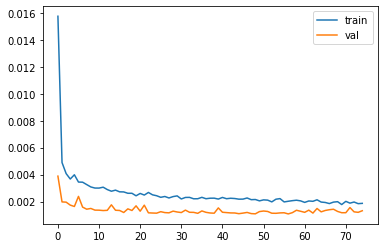

63/63 [==============================] - 3s 14ms/step


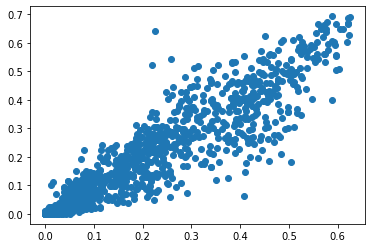

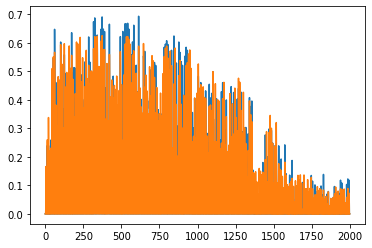

0.05380500380038101


In [59]:
def define_model():



  '''fe1_0 = Bidirectional(LSTM(208, activation='relu',return_sequences = True))(inputs1)
  fe1_1 = Dropout(0.5)(fe1_0)
  fe1_2 = Bidirectional(LSTM(24, activation='relu',return_sequences = True))(fe1_1)
  fe1_3= Dropout(0.2)(fe1_2)
  fe1_4=Bidirectional(LSTM(30, activation='relu'))(fe1_3)
  out1_1=Dense(1, activation='relu')(fe1_4)'''



  fe2_0 = Bidirectional(LSTM(208, activation='relu',return_sequences = True))(inputs1)
  fe2_1 = Dropout(0.6)(fe2_0)
  fe2_2 = Bidirectional(LSTM(60, activation='relu',return_sequences = True))(fe2_1)
  fe2_3= Dropout(0.5)(fe2_2)
  fe2_4=Bidirectional(LSTM(4, activation='relu'))(fe2_3)
  out2_1=Dense(1, activation='relu')(fe2_4)

  fe3_0 =Bidirectional(LSTM(104, activation='relu',return_sequences = True))(inputs1)
  fe3_1 = Dropout(0.6)(fe3_0)
  fe3_2 = Bidirectional(LSTM(96, activation='relu',return_sequences = True))(fe3_1)
  fe3_3= Dropout(0.5)(fe3_2)
  fe3_4=Bidirectional(LSTM(8, activation='relu'))(fe3_3)#16
  out3_1=Dense(1, activation='relu')(fe3_4)
 
 

  output = layers.average([ out3_1, out2_1])
  #merged3 = concatenate([out1_1,out2_1,out3_1], name='concat3')
  #output = Dense(1, activation='relu')( merged3)
  

  model = Model(inputs=[inputs1], outputs=[output])
  model.compile(optimizer =SPANDAN3(),loss='mean_squared_error',metrics=['mse'])
 
  return model
mdl=define_model()
history=mdl.fit(X_train, y_train, epochs = 75,validation_split=0.2,batch_size =64)
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()
y=mdl.predict(X_test)
plt.scatter(y,y_test)
plt.show()
df = pd.DataFrame()
df['time']=[i for i in range(len(y))]
df['Actual']=y_test
df['Predicted']=y
plt.plot(df['time'],df['Actual'])
plt.plot(df['time'],df['Predicted'])
plt.show()
print(np.sqrt(mean_squared_error(y,y_test)))

In [71]:
class SPANDAN3(Adam):
    def __init__(self, num_restarts=10, num_steps=100, lr=0.001, beta_1=0.9, beta_2=0.999,
                 epsilon=1e-8, decay=0., amsgrad=False, noise_std=0.1, **kwargs):
        super(SPANDAN3, self).__init__(lr, beta_1, beta_2, epsilon, decay, amsgrad, **kwargs)
        self.num_restarts = num_restarts
        self.num_steps = num_steps
        self.noise_std = noise_std
        self.best_loss = np.inf
        self.best_weights = None
        self.initial_weights = None
    
    def get_weights(self):
        return self.best_weights

    def set_weights(self, weights):
        self.best_weights = weights
        self.initial_weights = weights

    def on_train_begin(self, logs=None):
        self.best_loss = np.inf
        self.initial_weights = self.model.get_weights()

    def on_batch_end(self, batch, logs=None):
        current_loss = logs.get('loss')
        if current_loss < self.best_loss:
            self.best_loss = current_loss
            self.best_weights = self.model.get_weights()

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.num_restarts == 0 and epoch > 0:
            for _ in range(self.num_steps):
                self.model.fit(self.model.train_on_batch, epochs=1, verbose=0)
                current_loss = logs.get('loss')
                if current_loss < self.best_loss:
                    self.best_loss = current_loss
                    self.best_weights = self.model.get_weights()
            # calculate distance 
            distance = [np.linalg.norm(b - i) for b, i in zip(self.best_weights, self.initial_weights)]
            distance = sum(distance)/len(distance)
            
            # Adding noise to the best parameters
            params_1 = [b + (distance*self.noise_std) for b in self.best_weights]
            self.model.set_weights(params_1)
            self.initial_weights = params_1

            # subtract noise to the best parameters
            params_2 = [b - (distance*self.noise_std) for b in self.best_weights]
            self.model.set_weights(params_2)
            self.initial_weights = params_2

Epoch 1/75
51/51 [==============================] - 28s 153ms/step - loss: 0.0135 - mse: 0.0135 - val_loss: 0.0037 - val_mse: 0.0037
Epoch 2/75
51/51 [==============================] - 4s 86ms/step - loss: 0.0048 - mse: 0.0048 - val_loss: 0.0029 - val_mse: 0.0029
Epoch 3/75
51/51 [==============================] - 4s 83ms/step - loss: 0.0043 - mse: 0.0043 - val_loss: 0.0022 - val_mse: 0.0022
Epoch 4/75
51/51 [==============================] - 4s 83ms/step - loss: 0.0040 - mse: 0.0040 - val_loss: 0.0018 - val_mse: 0.0018
Epoch 5/75
51/51 [==============================] - 4s 83ms/step - loss: 0.0036 - mse: 0.0036 - val_loss: 0.0021 - val_mse: 0.0021
Epoch 6/75
51/51 [==============================] - 4s 85ms/step - loss: 0.0034 - mse: 0.0034 - val_loss: 0.0018 - val_mse: 0.0018
Epoch 7/75
51/51 [==============================] - 4s 88ms/step - loss: 0.0036 - mse: 0.0036 - val_loss: 0.0015 - val_mse: 0.0015
Epoch 8/75
51/51 [==============================] - 5s 89ms/step - loss: 0.0032 -

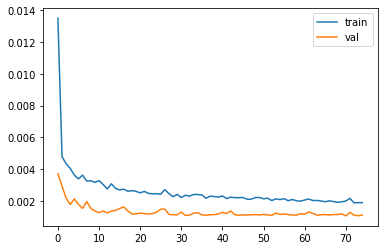

63/63 [==============================] - 4s 19ms/step


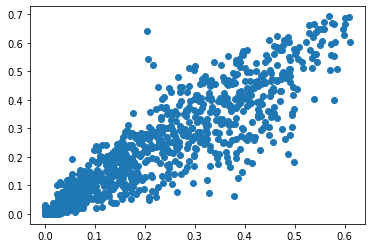

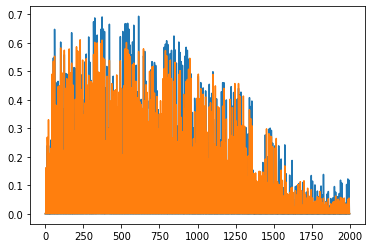

0.05517810920288665


In [72]:
def define_model():



  fe2_0 = Bidirectional(LSTM(208, activation='relu',return_sequences = True))(inputs1)
  fe2_1 = Dropout(0.6)(fe2_0)
  fe2_2 = Bidirectional(LSTM(60, activation='relu',return_sequences = True))(fe2_1)
  fe2_3= Dropout(0.5)(fe2_2)
  fe2_4=Bidirectional(LSTM(4, activation='relu'))(fe2_3)
  out2_1=Dense(1, activation='relu')(fe2_4)

  fe3_0 =Bidirectional(LSTM(104, activation='relu',return_sequences = True))(inputs1)
  fe3_1 = Dropout(0.6)(fe3_0)
  fe3_2 = Bidirectional(LSTM(96, activation='relu',return_sequences = True))(fe3_1)
  fe3_3= Dropout(0.5)(fe3_2)
  fe3_4=Bidirectional(LSTM(8, activation='relu'))(fe3_3)#16
  out3_1=Dense(1, activation='relu')(fe3_4)
 
 

  #output = layers.average([ out1_1, out2_1, out3_1])
  merged3 = concatenate([out2_1,out3_1], name='concat3')
  output = Dense(1, activation='relu')( merged3)
  

  model = Model(inputs=[inputs1], outputs=[output])
  model.compile(optimizer=SPANDAN3(),loss='mean_squared_error',metrics=['mse'])
 
  return model
mdl=define_model()
history=mdl.fit(X_train, y_train, epochs = 75,validation_split=0.2,batch_size =64)
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()
y=mdl.predict(X_test)
plt.scatter(y,y_test)
plt.show()
df = pd.DataFrame()
df['time']=[i for i in range(len(y))]
df['Actual']=y_test
df['Predicted']=y
plt.plot(df['time'],df['Actual'])
plt.plot(df['time'],df['Predicted'])
plt.show()
print(np.sqrt(mean_squared_error(y,y_test)))

In [ ]:
from keras.optimizers import Adam
from keras import backend as K
import numpy as np

class RandomRestartAdam(Adam):
    def __init__(self, num_restarts=10, num_steps=100, lr=0.001, beta_1=0.9, beta_2=0.999,
                 epsilon=1e-8, decay=0., amsgrad=False, noise_std=0.1, **kwargs):
        super(RandomRestartAdam, self).__init__(lr, beta_1, beta_2, epsilon, decay, amsgrad, **kwargs)
        self.num_restarts = num_restarts
        self.num_steps = num_steps
        self.noise_std = noise_std
        self.best_loss = np.inf
        self.best_weights = None

    def get_weights(self):
        return self.best_weights

    def set_weights(self, weights):
        self.best_weights = weights

    def on_train_begin(self, logs=None):
        self.best_loss = np.inf

    def on_batch_end(self, batch, logs=None):
        current_loss = logs.get('loss')
        if current_loss < self.best_loss:
            self.best_loss = current_loss
            self.best_weights = self.model.get_weights()

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.num_restarts == 0 and epoch > 0:
            for _ in range(self.num_steps):
                self.model.fit(self.model.train_on_batch, epochs=1, verbose=0)
                current_loss = logs.get('loss')
                if current_loss < self.best_loss:
                    self.best_loss = current_loss
                    self.best_weights = self.model.get_weights()
            if self.noise_std != 0:
                noise = K.random_normal(shape=K.shape(self.best_weights), mean=0., stddev=self.noise_std)
                self.best_weights = [w + n for w, n in zip(self.best_weights, noise)]
            self.model.set_weights(self.best_weights)


In [51]:
class SPANDAN1(Adam):
    def __init__(self, num_restarts=10, num_steps=100, lr=0.003, beta_1=0.9, beta_2=0.999,
                 epsilon=1e-8, decay=0., amsgrad=False, noise_std=0.1, **kwargs):
        super(SPANDAN1, self).__init__(lr, beta_1, beta_2, epsilon, decay, amsgrad, **kwargs)
        self.num_restarts = num_restarts
        self.num_steps = num_steps
        self.noise_std = noise_std
        self.best_loss = np.inf
        self.best_weights = None
        self.initial_weights = None
    
    def get_weights(self):
        return self.best_weights

    def set_weights(self, weights):
        self.best_weights = weights
        self.initial_weights = weights

    def on_train_begin(self, logs=None):
        self.best_loss = np.inf
        self.initial_weights = self.model.get_weights()

    def on_batch_end(self, batch, logs=None):
        current_loss = logs.get('loss')
        if current_loss < self.best_loss:
            self.best_loss = current_loss
            self.best_weights = self.model.get_weights()

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.num_restarts == 0 and epoch > 0:
            for _ in range(self.num_steps):
                self.model.fit(self.model.train_on_batch, epochs=1, verbose=0)
                current_loss = logs.get('loss')
                if current_loss < self.best_loss:
                    self.best_loss = current_loss
                    self.best_weights = self.model.get_weights()
            # calculate distance 
            distance = [np.linalg.norm(b - i) for b, i in zip(self.best_weights, self.initial_weights)]
            distance = sum(distance)/len(distance)
            
            # Adding noise to the best parameters
            params_1 = [b + (distance*self.noise_std) for b in self.best_weights]
            self.model.set_weights(params_1)
            self.initial_weights = params_1

            # subtract noise to the best parameters
            params_2 = [b - (distance*self.noise_std) for b in self.best_weights]
            self.model.set_weights(params_2)
            self.initial_weights = params_2

In [52]:
class SPANDAN2(Adam):
    def __init__(self, num_restarts=10, num_steps=100, lr=0.002, beta_1=0.9, beta_2=0.999,
                 epsilon=1e-8, decay=0., amsgrad=False, noise_std=0.1, **kwargs):
        super(SPANDAN2, self).__init__(lr, beta_1, beta_2, epsilon, decay, amsgrad, **kwargs)
        self.num_restarts = num_restarts
        self.num_steps = num_steps
        self.noise_std = noise_std
        self.best_loss = np.inf
        self.best_weights = None
        self.initial_weights = None
    
    def get_weights(self):
        return self.best_weights

    def set_weights(self, weights):
        self.best_weights = weights
        self.initial_weights = weights

    def on_train_begin(self, logs=None):
        self.best_loss = np.inf
        self.initial_weights = self.model.get_weights()

    def on_batch_end(self, batch, logs=None):
        current_loss = logs.get('loss')
        if current_loss < self.best_loss:
            self.best_loss = current_loss
            self.best_weights = self.model.get_weights()

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.num_restarts == 0 and epoch > 0:
            for _ in range(self.num_steps):
                self.model.fit(self.model.train_on_batch, epochs=1, verbose=0)
                current_loss = logs.get('loss')
                if current_loss < self.best_loss:
                    self.best_loss = current_loss
                    self.best_weights = self.model.get_weights()
            # calculate distance 
            distance = [np.linalg.norm(b - i) for b, i in zip(self.best_weights, self.initial_weights)]
            distance = sum(distance)/len(distance)
            
            # Adding noise to the best parameters
            params_1 = [b + (distance*self.noise_std) for b in self.best_weights]
            self.model.set_weights(params_1)
            self.initial_weights = params_1

            # subtract noise to the best parameters
            params_2 = [b - (distance*self.noise_std) for b in self.best_weights]
            self.model.set_weights(params_2)
            self.initial_weights = params_2

In [66]:
class SPANDAN3(Adam):
    def __init__(self, num_restarts=10, num_steps=100, lr=0.001, beta_1=0.9, beta_2=0.999,
                 epsilon=1e-8, decay=0., amsgrad=False, noise_std=0.1, **kwargs):
        super(SPANDAN3, self).__init__(lr, beta_1, beta_2, epsilon, decay, amsgrad, **kwargs)
        self.num_restarts = num_restarts
        self.num_steps = num_steps
        self.noise_std = noise_std
        self.best_loss = np.inf
        self.best_weights = None
        self.initial_weights = None
    
    def get_weights(self):
        return self.best_weights

    def set_weights(self, weights):
        self.best_weights = weights
        self.initial_weights = weights

    def on_train_begin(self, logs=None):
        self.best_loss = np.inf
        self.initial_weights = self.model.get_weights()

    def on_batch_end(self, batch, logs=None):
        current_loss = logs.get('loss')
        if current_loss < self.best_loss:
            self.best_loss = current_loss
            self.best_weights = self.model.get_weights()

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.num_restarts == 0 and epoch > 0:
            for _ in range(self.num_steps):
                self.model.fit(self.model.train_on_batch, epochs=1, verbose=0)
                current_loss = logs.get('loss')
                if current_loss < self.best_loss:
                    self.best_loss = current_loss
                    self.best_weights = self.model.get_weights()
            # calculate distance 
            distance = [np.linalg.norm(b - i) for b, i in zip(self.best_weights, self.initial_weights)]
            distance = sum(distance)/len(distance)
            
            # Adding noise to the best parameters
            params_1 = [b + (distance*self.noise_std) for b in self.best_weights]
            self.model.set_weights(params_1)
            self.initial_weights = params_1

            # subtract noise to the best parameters
            params_2 = [b - (distance*self.noise_std) for b in self.best_weights]
            self.model.set_weights(params_2)
            self.initial_weights = params_2

In [31]:
from keras.optimizers import Adam
from keras.layers import Bidirectional, LSTM, Dense
from keras.models import Sequential

# Define the model
model = Sequential()
model.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=(3, 16)))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(1, activation='relu'))

# Define optimizers for different layers
lstm_1_optimizer = SPANDAN1()
lstm_2_optimizer = SPANDAN2()
dense_optimizer = SPANDAN3()

# Compile the model with the custom optimizers
model.compile(optimizer=dense_optimizer,loss='mean_squared_error',metrics=['mse'])

# Set the optimizers for the layers
model.layers[0].layer.trainable = True
model.layers[0].layer.optimizer = lstm_1_optimizer
model.layers[1].layer.trainable = True
model.layers[1].layer.optimizer = lstm_2_optimizer


Epoch 1/100
51/51 [==============================] - 11s 50ms/step - loss: 0.0086 - mse: 0.0086 - val_loss: 0.0030 - val_mse: 0.0030
Epoch 2/100
51/51 [==============================] - 1s 14ms/step - loss: 0.0042 - mse: 0.0042 - val_loss: 0.0027 - val_mse: 0.0027
Epoch 3/100
51/51 [==============================] - 1s 14ms/step - loss: 0.0036 - mse: 0.0036 - val_loss: 0.0021 - val_mse: 0.0021
Epoch 4/100
51/51 [==============================] - 1s 14ms/step - loss: 0.0034 - mse: 0.0034 - val_loss: 0.0022 - val_mse: 0.0022
Epoch 5/100
51/51 [==============================] - 1s 14ms/step - loss: 0.0034 - mse: 0.0034 - val_loss: 0.0020 - val_mse: 0.0020
Epoch 6/100
51/51 [==============================] - 1s 14ms/step - loss: 0.0032 - mse: 0.0032 - val_loss: 0.0023 - val_mse: 0.0023
Epoch 7/100
51/51 [==============================] - 1s 14ms/step - loss: 0.0033 - mse: 0.0033 - val_loss: 0.0019 - val_mse: 0.0019
Epoch 8/100
51/51 [==============================] - 1s 14ms/step - loss: 0

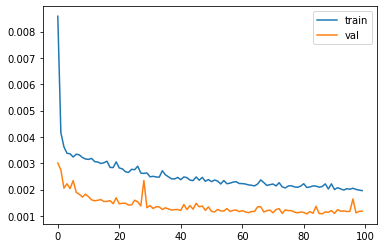

63/63 [==============================] - 1s 15ms/step


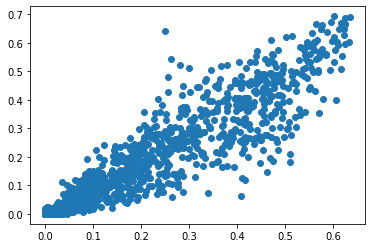

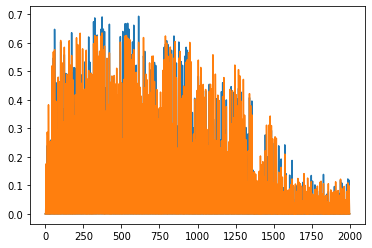

0.05706692757115133


In [32]:
history=model.fit(X_train, y_train, epochs = 100,validation_split=0.2,batch_size =64)
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()
y=mdl.predict(X_test)
plt.scatter(y,y_test)
plt.show()
df = pd.DataFrame()
df['time']=[i for i in range(len(y))]
df['Actual']=y_test
df['Predicted']=y
plt.plot(df['time'],df['Actual'])
plt.plot(df['time'],df['Predicted'])
plt.show()
print(np.sqrt(mean_squared_error(y,y_test)))

In [54]:
lstm_1_optimizer = SPANDAN1()
lstm_2_optimizer = SPANDAN2()
dense_optimizer = SPANDAN3()


In [55]:
model = Sequential()
model.add(Bidirectional(LSTM(208,activation='relu',return_sequences=True), input_shape=(3, 16)))
model.add(Dropout(0.6))
model.add(Bidirectional(LSTM(60,activation='relu',return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(4,activation='relu')))
model.add(Dense(1, activation='relu'))
model.compile(optimizer=dense_optimizer,loss='mean_squared_error',metrics=['mse'])
model.layers[0].layer.trainable = True
model.layers[0].layer.optimizer = lstm_1_optimizer
model.layers[2].layer.trainable = True
model.layers[2].layer.optimizer = lstm_2_optimizer
model.layers[4].layer.trainable = True
model.layers[4].layer.optimizer = lstm_2_optimizer


In [56]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_56 (Bidirecti  (None, 3, 416)           374400    
 onal)                                                           
                                                                 
 dropout_48 (Dropout)        (None, 3, 416)            0         
                                                                 
 bidirectional_57 (Bidirecti  (None, 3, 120)           228960    
 onal)                                                           
                                                                 
 dropout_49 (Dropout)        (None, 3, 120)            0         
                                                                 
 bidirectional_58 (Bidirecti  (None, 8)                4000      
 onal)                                                           
                                                      

Epoch 1/75
51/51 [==============================] - 6s 108ms/step - loss: 0.0164 - mse: 0.0164 - val_loss: 0.0062 - val_mse: 0.0062
Epoch 2/75
51/51 [==============================] - 3s 52ms/step - loss: 0.0055 - mse: 0.0055 - val_loss: 0.0025 - val_mse: 0.0025
Epoch 3/75
51/51 [==============================] - 3s 52ms/step - loss: 0.0047 - mse: 0.0047 - val_loss: 0.0020 - val_mse: 0.0020
Epoch 4/75
51/51 [==============================] - 3s 51ms/step - loss: 0.0041 - mse: 0.0041 - val_loss: 0.0019 - val_mse: 0.0019
Epoch 5/75
51/51 [==============================] - 3s 61ms/step - loss: 0.0039 - mse: 0.0039 - val_loss: 0.0017 - val_mse: 0.0017
Epoch 6/75
51/51 [==============================] - 3s 65ms/step - loss: 0.0037 - mse: 0.0037 - val_loss: 0.0016 - val_mse: 0.0016
Epoch 7/75
51/51 [==============================] - 3s 53ms/step - loss: 0.0037 - mse: 0.0037 - val_loss: 0.0019 - val_mse: 0.0019
Epoch 8/75
51/51 [==============================] - 3s 53ms/step - loss: 0.0037 - 

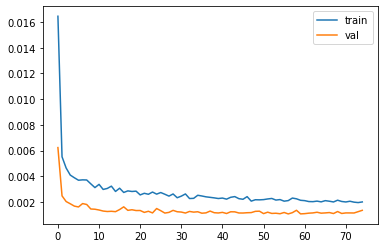

63/63 [==============================] - 1s 16ms/step


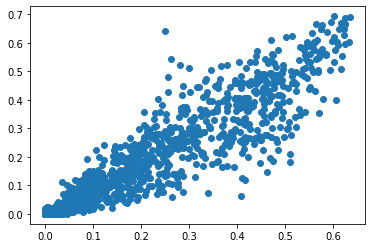

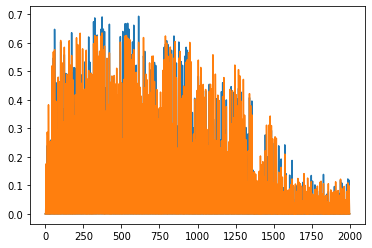

0.05706692757115133


In [58]:

history=model.fit(X_train, y_train, epochs =75,validation_split=0.2,batch_size =64)
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()
y=mdl.predict(X_test)
plt.scatter(y,y_test)
plt.show()
df = pd.DataFrame()
df['time']=[i for i in range(len(y))]
df['Actual']=y_test
df['Predicted']=y
plt.plot(df['time'],df['Actual'])
plt.plot(df['time'],df['Predicted'])
plt.show()
print(np.sqrt(mean_squared_error(y,y_test)))